# Remake Figure 2

Author: Jacob Parres-Gold (jparresau@caltech.edu)

Last Revised: 20231019

This notebook is designed to reproduce figures from the paper using the archived data folder. Each section should be possible to run independently.

Note that this notebook is primarily intended for users who wish to replot the existing data in different ways; it does not include code for the analysis itself.

In [1]:
import importlib
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats
import sys
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

In [2]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)

from dimer_network_utilities import *

In [ ]:
# Define directory of the archived data folder parresgold_2023_dimer_networks_data
load_dir = str(pathlib.Path('E:\\','parresgold_2023_dimer_networks','parresgold_2023_dimer_networks_data'))

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [5]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [6]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.3
matplotlib=3.7.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Simulation Functions for all Figure 2

In [7]:
def run_eqtk(N, C0, params, acc_monomer_ind):
    """
    Run eqtk.solve given the input stoichiometry matrix, initial concentrations, and parameters.

    See eqtk.solve documentation for more details on the syntax.
    (https://eqtk.github.io/user_guide/generated/highlevel/eqtk.solve.html)

    Parameters
    ----------
    N : Array-like, shape (num_rxns, num_species)
        Input stoichiometry matrix
    C0 : Array-like, shape (num_simulation_points, num_species)
        Initial concentrations of all species for each simulation point.
        Accessory monomer levels will be set based on params.
    params : List-like, len num_combos_with_replacement(m,2) + (m-1)
        Parameters including Kij values and accessory monomer levels
    acc_monomer_ind : int  
        Index of accessory monomers in species list
    
    Returns
    -------
    C: Array-like
        Equilibrium concentrations of all species
    """
    num_rxns = N.shape[0]
    # Extract Kij values
    K = params[:num_rxns]
    # Set accessory monomer levels
    C0[:,acc_monomer_ind] = params[num_rxns:]

    return eqtk.solve(c0=C0, N=N, K=K)

In [8]:
def simulate_networks(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a titration of concentrations for each input monomer. 
    When >1 input monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, 
    while the second is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species in the network.
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. Log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species.Llog10 scale
    param_sets : Array-like, shape (num_sets, num_parameters)
        Parameter sets for simulating multiple dimerization networks.  
    Returns
    -------
    C0 : Array-like, shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : Array-like, shape (t, number of species, num_sets) 
        Equlibrium concentration of all species
        for all parameter sets and each input titration point.
        
    """
    # Create stoichiometry matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]

    # Create initial concentration array
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs) # Species concentrations at min of inputs
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs) # Species concentrations at max of inputs
    num_conc = [t]*num_inputs + [1] * (m-num_inputs) # Number of concentrations to titrate for each species
    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc) 
        
    acc_monomer_ind = np.arange(num_inputs,m) # Indices of accessory monomers
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    # For each parameter set, run eqtk.solve
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  

## Figure 2A-D (One-input Functions)

### Figure 2A - Switch Off

In [28]:
m=2
num_inputs = 1
name = 'switch_off' 
param_sets = np.array([[1e-10, 1e3, 1e-2,1e1]])
dimer_of_interest = make_nXn_species_names(m).index('D_2_2') - m # Index of dimer to use as output (D_1_1 = index 0)

r_node = 0.225

out_range = [1e-3,1e1] # Output concentration range

### Figure 2B - Switch On

In [31]:
m=3
num_inputs = 1
name = 'switch_on' 
param_sets = np.array([[1e-10,  1e2, 1e-10, 1e-10,1e1, 1e1, 1e1, 1]])
dimer_of_interest = make_nXn_species_names(m).index('D_3_3') - m # Index of dimer to use as output (D_1_1 = index 0)

r_node = 0.3

out_range = [1e-3,1e1] # Output concentration range

### Figure 2C - Band-pass Filter

In [44]:
m=3
num_inputs = 1
name = 'bandpass' 
param_sets = np.array([[1e-10, 1e3, 1, 1e-10, 1e3, 1, 1, 1]])
dimer_of_interest = make_nXn_species_names(m).index('D_3_3') - m # Index of dimer to use as output (D_1_1 = index 0)

r_node = 0.3

out_range = [1e-3,1e0] # Output concentration range

### Figure 2D - Band-stop Filter

In [23]:
m=4
num_inputs = 1
name = 'bandstop' 
param_sets = np.array([[1e-10, 1e3, 1, 1e-10, 1e-10, 1e3, 1e-10, 1e-10, 1e3, 5e+3, 5, 5, 5e-1]])
dimer_of_interest = make_nXn_species_names(m).index('D_4_4') - m # Index of dimer to use as output (D_1_1 = index 0)

r_node = 0.3

out_range = [1e-3,1e0] # Output concentration range

### Figure 2A-D: Plot

#### Response

In [48]:
t=120 # Number of input titration points
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

C0,S_all  = simulate_networks(m, num_inputs=1,param_sets=param_sets, t = t, input_lb = input_lb, input_ub = input_ub)

In [49]:
plot_all_dimers = False # Whether to plot all dimers, or just dimer of interest
highlight_dimer_of_interest = True # If plotting all dimers, color dimer of interest solid black

save = True # Whether to save plots to out_dir

# out_range = [1e-3,1e1] # Output concentration range

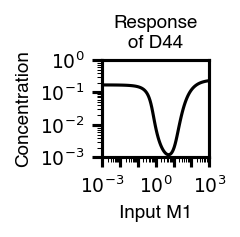

In [50]:
# Plot a desired response

min_affinity = 1e-5 # Will not plot dimers below this affinity (assumed not to dimerize)

fig, ax = plt.subplots(figsize=(0.92,0.845))

monomer_cmap = plt.get_cmap('Set2')
dimer_cmap = plt.get_cmap('tab10')
# dimer_cmap = plt.get_cmap('tab20')

x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

if plot_all_dimers:
    for species in range(number_of_species(m)):
        alpha=0.5
        if species<m:
            color = monomer_cmap(species)
        else:
            color = dimer_cmap(species-m)
            if param_sets[0,species-m]<min_affinity:
                continue
        if highlight_dimer_of_interest and species==m+dimer_of_interest:
            color='k'
            alpha=1
        ax.plot(x_points,S_all[:,species,0],marker=None,linestyle='-',color=color,\
                    alpha=alpha,lw=1)
else:
    ax.plot(x_points,S_all[:,m+dimer_of_interest,0],marker=None,linestyle='-',color='k',\
                    alpha=1,lw=1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([10**input_lb,10**input_ub])
ax.set_ylim(out_range)
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
# Set ticks
set_simple_log_ticks(ax,which='x',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)

out_range_lb,out_range_ub = np.round(np.log10(out_range),decimals=0).astype('int')
set_simple_log_ticks(ax,which='y',log_lowerbound=out_range_lb,log_upperbound=out_range_ub,max_labels=4)

_ = ax.set_xlabel('Input M1')
_ = ax.set_ylabel('Concentration')

# Customize spines
set_spine_linewidth(ax,1)

# Customize the major ticks
ax.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

# Customize the minor ticks
ax.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks

ax.set_aspect(1) # Ensure that plot area is a perfect square

# Create legend, if necessary
if plot_all_dimers:
    patches={}
    for species in range(m):
        patches[f'M{species+1}'] = mpatches.Patch(facecolor=monomer_cmap(species),linewidth=0,linestyle='',\
                                                  alpha=0.5,label=f'Free M{species+1}',edgecolor=None)
    for species in range(m,number_of_species(m)):
        if param_sets[0,species-m]<min_affinity:
            continue
        color = dimer_cmap(species-m)
        alpha=0.5
        if highlight_dimer_of_interest and species==m+dimer_of_interest:
            color='k'
            alpha=1
        patches[f'D{species+1}'] = mpatches.Patch(facecolor=color,linewidth=0,linestyle='',\
                                                  alpha=alpha,label=make_nXn_species_names(m = m)[species],\
                                                  edgecolor=None)

    leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='none',\
        handles=list(patches.values()),\
        edgecolor='none')
else:
    _ = ax.set_title('Response\nof {}'.format(make_nXn_species_names(m)[m+dimer_of_interest].replace('_','')))

fig.set_dpi(150)

if save:
    if plot_all_dimers:
        dimers_label = '_all_dimers'
    else:
        dimers_label = ''
    filename = f'Fig2_{m}M_{name}_responses{dimers_label}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

#### Schematic

In [25]:
save = True

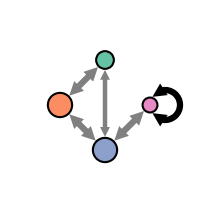

In [27]:
fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=param_sets, # Parameter sets to draw from
                                        dimers_of_interest=np.array([[dimer_of_interest]]), # Index of output dimer
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        input_node_values=np.array([0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = r_node, # Radius of nodes around center
                                        r_loop = 0.2, # Radius of loops around nodes 
                                        node_scales = [-1,1,5,14], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap='Set2', # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
                                        labels=False,
)

fig.set_dpi(150)

if save:
    filename = f'Fig2_{m}M_{name}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),pad_inches=0,bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,pad_inches=0,bbox_inches='tight')

## Figure 2E-H (Two-input Functions)

### Figure 2E - M1 NOT M2 (NIMPLY)

In [48]:
m=4
num_inputs = 2
name = 'ANOTB' # AKA NIMPLY
param_sets = np.array([[3.0, 1e-10, 3, 10000, 1e-10, 10000, 1e-10, 1e-10, 1e-10, 1e-10, 1.0, 1.0]])
dimer_of_interest = make_nXn_species_names(m).index('D_1_3') - m # Index of dimer to use as output (D_1_1 = index 0)

# Switch M1 and M2 for visualization
param_sets_schematic = swap_monomer_labels(m,num_inputs,param_sets,map={1:2,2:1})
dimer_of_interest_schematic = make_nXn_species_names(m).index('D_2_3') - m # Index of dimer to use as output (D_1_1 = index 0)

out_range = [1e-3,1e1] # Range of output concentrations

r_node = 0.3
r_loop = 0.1

### Figure 2F - NAND Gate

In [52]:
m=4
num_inputs = 2
name = 'NAND' 
param_sets = np.array([[50.0, 1e-10, 1e-10, 10000.0, 50.0, 10000.0, 1e-10, 1e-10, 10000.0, 1e-10, 1.0, 1.0]])
dimer_of_interest = make_nXn_species_names(m).index('D_3_4') - m # Index of dimer to use as output (D_1_1 = index 0)

# Switch M1 and M2 for visualization
param_sets_schematic = swap_monomer_labels(m,num_inputs,param_sets,map={1:2,2:1,3:4,4:3})
dimer_of_interest_schematic = make_nXn_species_names(m).index('D_3_4') - m # Index of dimer to use as output (D_1_1 = index 0)

out_range = [1e-3,1e1] # Range of output concentrations

r_node = 0.3
r_loop = 0.1

### Figure 2G - Two-input Band-pass Filter

In [72]:
m=5
num_inputs = 2
name = '2D_bandpass' 
param_sets = np.array([[1e-10, 1e-10, 1e-10, 10000.0, 20.0, 1e-10, 10000.0, 1e-10, 20.0, 1e-10,\
                        1e-10, 10000.0, 1e-10, 10000.0, 100.0, 5.0, 5.0, 3.7]])
dimer_of_interest = make_nXn_species_names(m).index('D_5_5') - m # Index of dimer to use as output (D_1_1 = index 0)

param_sets_schematic = swap_monomer_labels(m,num_inputs,param_sets,map={1:2,2:1})
param_sets_schematic = swap_monomer_labels(m,num_inputs,param_sets_schematic,map={5:4,4:5})
param_sets_schematic = swap_monomer_labels(m,num_inputs,param_sets_schematic,map={3:5,5:3})
dimer_of_interest_schematic = make_nXn_species_names(m).index('D_4_4') - m # Index of dimer to use as output (D_1_1 = index 0)

r_node = 0.4
r_loop = 0.2

out_range = [1e-3,1e0] # Range of output concentrations

### Figure 2H - XOR Gate

In [70]:
m=6
num_inputs = 2
name = 'XOR' 
param_sets = np.array([[1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 10000.0, 1e-10, 10000.0, 1e-10, 1e-10, 1e-10, \
                        1e-10, 1e-10, 10000.0, 10000.0, 100.0, 10000.0, 1e-10, 1e-10, 10000.0, 1e-10, 2.0, 0.1, 1.0, 2.0]])
dimer_of_interest = make_nXn_species_names(m).index('D_4_4') - m # Index of dimer to use as output (D_1_1 = index 0)

param_sets_schematic = param_sets
dimer_of_interest_schematic = make_nXn_species_names(m).index('D_4_4') - m # Index of dimer to use as output (D_1_1 = index 0)

r_node = 0.4
r_loop = 0.2

out_range = [1e-3,1e-1] # Range of output concentrations

### Figure 2E-H: Plot

#### Response

In [126]:
t=30 # Number of input titration points, in each dimension
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

C0,S_all  = simulate_networks(m, num_inputs=2,param_sets=param_sets, t = t, input_lb = input_lb, input_ub = input_ub)

In [127]:
plot_all_dimers = False # Whether to plot all dimers, or just dimer of interest

save = True # Whether to save plots to out_dir

# out_range = [1e-3,1e0] # Range of output concentrations

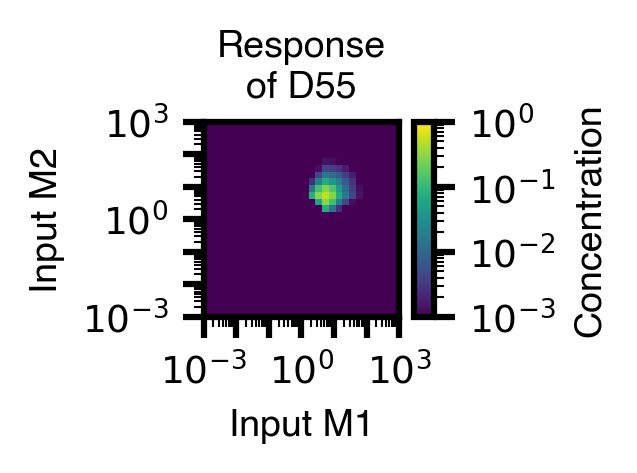

In [128]:
# Plot a desired response

if plot_all_dimers:
    ncols = 5
    nrows = math.ceil(number_of_species(m=m)/ncols)
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*4,nrows*3))
else:
    ncols= 1
    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(0.99,0.845))
    axs = np.array([[axs]])

cmap = plt.get_cmap('viridis')

x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

for species in range(number_of_species(m)):
    if (not plot_all_dimers) and species>0:
        continue
    row = species//ncols
    col = species%ncols
    # Need to take transpose so that M1 appears on X-axis
    if plot_all_dimers:
        matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,species,0].reshape((t,t)).T,\
                                     cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)
        # shading='gouraud' or shading='nearest'
    else:
        matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,m+dimer_of_interest,0].reshape((t,t)).T,\
                                     cmap = cmap,norm=mpl.colors.LogNorm(vmin=out_range[0],vmax=out_range[1]),\
                                     shading = 'nearest',rasterized=True)
        # shading='gouraud' or shading='nearest'
    axs[row,col].xaxis.set_ticks_position("bottom")
    axs[row,col].set_xscale('log')
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(f'Input M1')
    axs[row,col].set_ylabel(f'Input M2')
    axs[row,col].set_aspect(1) # Ensure that plot area is a perfect square
    axs[row,col].set_xlim([10**input_lb,10**input_ub])
    axs[row,col].set_ylim([10**input_lb,10**input_ub])
    axs[row,col].xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    axs[row,col].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    # Set ticks
    set_simple_log_ticks(axs[row,col],which='both',log_lowerbound=input_lb,log_upperbound=input_ub,max_labels=4)

    if plot_all_dimers:
        _ = axs[row,col].set_title(make_nXn_species_names(m=m)[species].replace('_',''))
    else:
        _ = axs[row,col].set_title('Dimer {}'.format(make_nXn_species_names(m=m)[m+dimer_of_interest].replace('_','')))
    # Add colorbar
    divider = make_axes_locatable(axs[row,col])
    cax1 = divider.append_axes("right", size="10%", pad=0.05)
    colorbar = fig.colorbar(matrix,cax=cax1,label='Concentration')
    cax1.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

    # Set colorbar ticks
    set_simple_log_ticks(cax1,which='y',log_lowerbound=int(np.log10(out_range[0])),log_upperbound=int(np.log10(out_range[1])),max_labels=4)

    # Customize spines
    set_spine_linewidth(axs[row,col],1)
    colorbar.outline.set_linewidth(1)

    # Customize the major ticks
    axs[row,col].tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks
    cax1.tick_params(axis='both', which='major', length=5, width=1)  # Length and linewidth of major ticks

    # Customize the minor ticks
    axs[row,col].tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks
    cax1.tick_params(axis='both', which='minor', length=2.5, width=0.25)   # Length and linewidth of minor ticks


# Remove extra axes
if plot_all_dimers:
    # Adjust subplot aspect ratio
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.7,
                        hspace=0.5)
    for extra_ax in range(number_of_species(m),nrows*ncols):
        row = extra_ax//ncols
        col = extra_ax-(row*ncols)
        axs[row,col].remove()

fig.set_dpi(300)

if save:
    if plot_all_dimers:
        dimers_label = '_all_dimers'
    else:
        dimers_label = ''
    filename = f'Fig2_{m}M_{name}_responses{dimers_label}'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),pad_inches=0,bbox_inches='tight',transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,pad_inches=0,bbox_inches='tight')

#### Schematic

In [61]:
# Recall M1 and M2 are swapped for this schematic
Set2 = plt.get_cmap('Set2')
Set2_swapped = mcolors.ListedColormap([Set2(1),Set2(0)]+[Set2(i) for i in range(2,8)])

Set2_swapped_doublebandpass = mcolors.ListedColormap([Set2(1),Set2(0),Set2(2),Set2(4),\
                                                      Set2(3),Set2(5),Set2(6),Set2(7)])

In [62]:
save = True

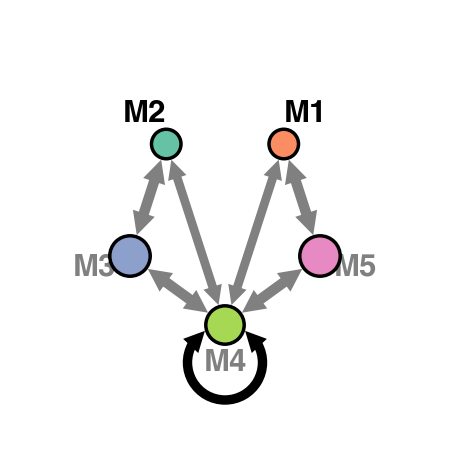

In [73]:
if name=='2D_bandpass':
    cmap_to_use = Set2_swapped_doublebandpass
else:
    cmap_to_use = Set2_swapped

fig, axs = make_network_plots_polygon(m=m, # Number of monomers
                                        n_input=num_inputs, # Number of inputs
                                        param_sets=param_sets_schematic, # Parameter sets to draw from
                                        univs_to_plot=np.array([0]), # Indicies of param_sets to plot
                                        dimers_of_interest=np.array([[dimer_of_interest_schematic]]), # Index of output dimer
                                        input_node_values=np.array([0,0]), # Abundances to use for input node(s), log scale
                                        ncols = 1, # Number of columns in figure
                                        r_node = r_node, # Radius of nodes around center
                                        r_loop = r_loop, # Radius of loops around nodes 
                                        node_scales = [-1,1,5,14], # Scales for node sizes (lower and upper bounds in log scale, min and max sizes)
                                        K_edge_scales = [-4,3,1,3], # Scales for edge widths (lower and upper bounds in log scale, min and max widths)
                                        input_cmap=cmap_to_use, # Colormap for nodes
                                        fontname='Helvetica', # Font name
                                        fontsize=9, # Font size
                                        non_output_dimer_color='gray',
                                        upscale_arrowhead=1.1,
                                        node_edge_width=1,
)

fig.set_dpi(250)

if save:
    filename = f'Fig2_{m}M_{name}_schematic'
    plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),bbox_inches='tight',pad_inches=0,transparent=True)
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,pad_inches=0,bbox_inches='tight')